In [1]:
import gc
import keras
import librosa
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
print(tf.config.list_physical_devices('GPU'))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def preprocess(dataset_path, n_fft=2048, hop_length=512, num_segment=10):
    # all_mfcc = np.empty([1000 * num_segment, 40, 130])
    # all_spec = np.empty([1000 * num_segment, 1025, 130])
    all_mel = np.empty([1000 * num_segment, 128, 130], dtype=np.float32)
    # all_chroma = np.empty([1000 * num_segment, 12, 130])
    labels = np.empty([1000 * num_segment], dtype=np.int32)
    sample_rate = 22050
    sample_per_segment = int(sample_rate*30/num_segment)

    count = 0
    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath == dataset_path:
            continue

        for f in sorted(filenames):
            if not f.endswith('.wav'):
                continue
            file_path = str(str(dirpath).split('\\')[-1]) + '/' + str(f)
            print("Track Name", file_path)

            try:
                y, sr = librosa.load(path=dirpath + "\\" + f, sr=sample_rate)
            except:
                print("Exception")
                continue

            for n in range(num_segment):
                segment = y[sample_per_segment*n: sample_per_segment*(n + 1)]
                # Get mel-spectrogram
                mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft, hop_length=hop_length, dtype=np.float32)
                mel_db = librosa.power_to_db(mel)
                if mel_db.shape[0] == all_mel.shape[1] and mel_db.shape[1] == all_mel.shape[2]:
                    all_mel[count] = mel_db
                    labels[count] = label_idx - 1
                    count += 1

    # all_mfcc = all_mfcc.astype(np.float32)
    # all_spec = all_spec.astype(np.float32)
    # all_mel = all_mel.astype(np.float32)
    # all_chroma = all_chroma.astype(np.float32)
    print(count)
    all_mel = np.delete(all_mel, np.s_[count:], axis=0)
    labels = np.delete(labels, np.s_[count:])
    return all_mel, labels

In [3]:
x, y = preprocess(r"C:\Users\dpetr\Desktop\sxoli\music genre classification\MFCC-CNN\Data\genres_original")

print(x.shape, x.dtype, y.shape, y.dtype)

Track Name blues/blues.00000.wav
Track Name blues/blues.00001.wav
Track Name blues/blues.00002.wav
Track Name blues/blues.00003.wav
Track Name blues/blues.00004.wav
Track Name blues/blues.00005.wav
Track Name blues/blues.00006.wav
Track Name blues/blues.00007.wav
Track Name blues/blues.00008.wav
Track Name blues/blues.00009.wav
Track Name blues/blues.00010.wav
Track Name blues/blues.00011.wav
Track Name blues/blues.00012.wav
Track Name blues/blues.00013.wav
Track Name blues/blues.00014.wav
Track Name blues/blues.00015.wav
Track Name blues/blues.00016.wav
Track Name blues/blues.00017.wav
Track Name blues/blues.00018.wav
Track Name blues/blues.00019.wav
Track Name blues/blues.00020.wav
Track Name blues/blues.00021.wav
Track Name blues/blues.00022.wav
Track Name blues/blues.00023.wav
Track Name blues/blues.00024.wav
Track Name blues/blues.00025.wav
Track Name blues/blues.00026.wav
Track Name blues/blues.00027.wav
Track Name blues/blues.00028.wav
Track Name blues/blues.00029.wav
Track Name

C:\Users\dpetr\miniconda3\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Track Name jazz/jazz.00056.wav
Track Name jazz/jazz.00057.wav
Track Name jazz/jazz.00058.wav
Track Name jazz/jazz.00059.wav
Track Name jazz/jazz.00060.wav
Track Name jazz/jazz.00061.wav
Track Name jazz/jazz.00062.wav
Track Name jazz/jazz.00063.wav
Track Name jazz/jazz.00064.wav
Track Name jazz/jazz.00065.wav
Track Name jazz/jazz.00066.wav
Track Name jazz/jazz.00067.wav
Track Name jazz/jazz.00068.wav
Track Name jazz/jazz.00069.wav
Track Name jazz/jazz.00070.wav
Track Name jazz/jazz.00071.wav
Track Name jazz/jazz.00072.wav
Track Name jazz/jazz.00073.wav
Track Name jazz/jazz.00074.wav
Track Name jazz/jazz.00075.wav
Track Name jazz/jazz.00076.wav
Track Name jazz/jazz.00077.wav
Track Name jazz/jazz.00078.wav
Track Name jazz/jazz.00079.wav
Track Name jazz/jazz.00080.wav
Track Name jazz/jazz.00081.wav
Track Name jazz/jazz.00082.wav
Track Name jazz/jazz.00083.wav
Track Name jazz/jazz.00084.wav
Track Name jazz/jazz.00085.wav
Track Name jazz/jazz.00086.wav
Track Name jazz/jazz.00087.wav
Track Na

In [4]:
def build_model(input_shape):

    #create model
    model = keras.Sequential()

    #1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.000005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='same'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    #2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.000005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='same'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    #3rd conv layer
    model.add(keras.layers.Conv2D(256, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.000005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='valid'))
    # model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
    model.add(keras.layers.Dropout(0.65))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8987, 128, 130, 1) (8987,) Test:  (999, 128, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

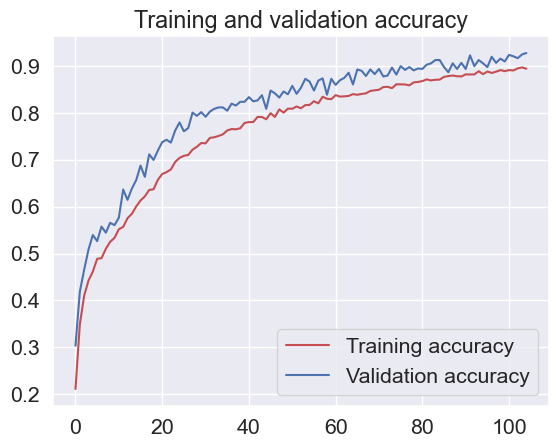

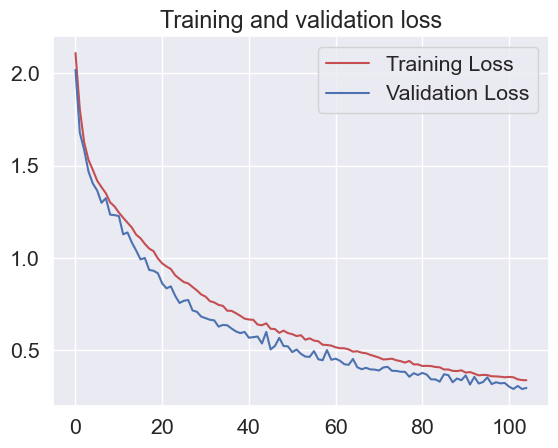

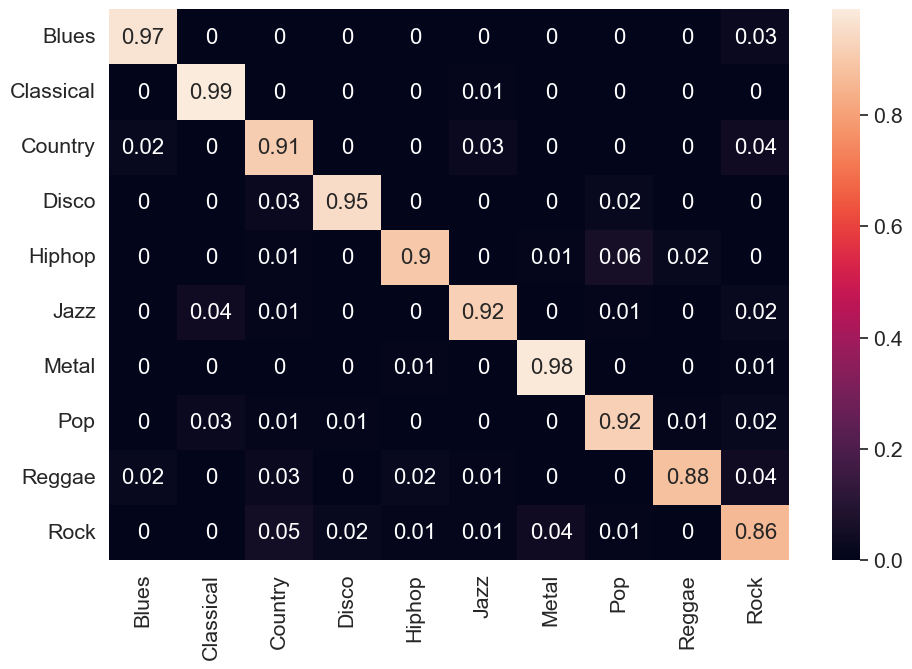

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8987, 128, 130, 1) (8987,) Test:  (999, 128, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

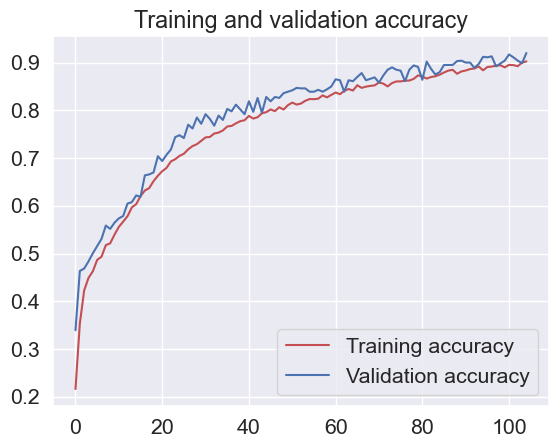

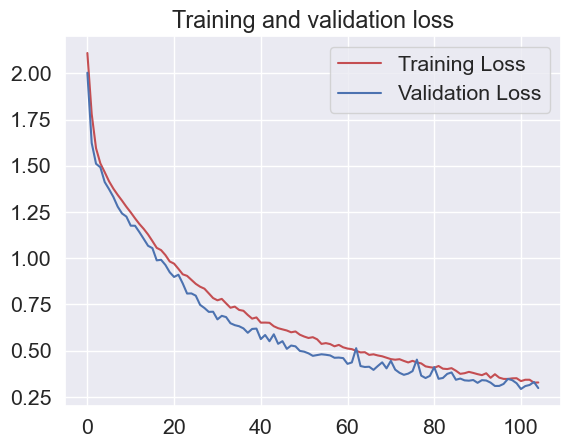

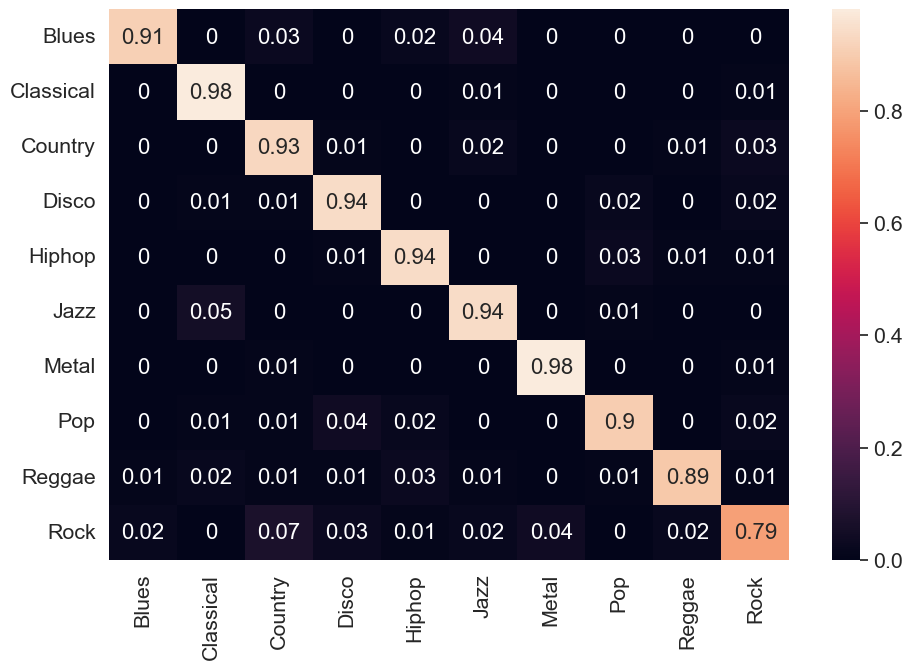

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8987, 128, 130, 1) (8987,) Test:  (999, 128, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

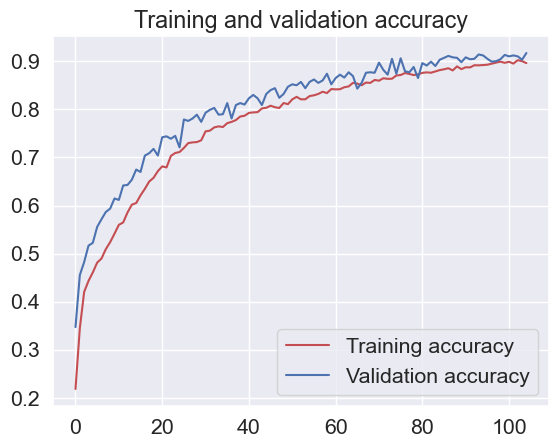

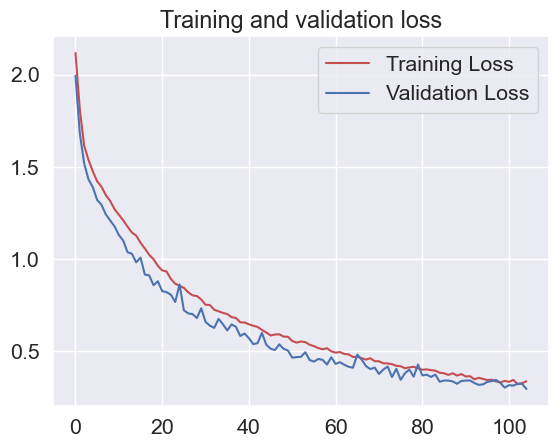

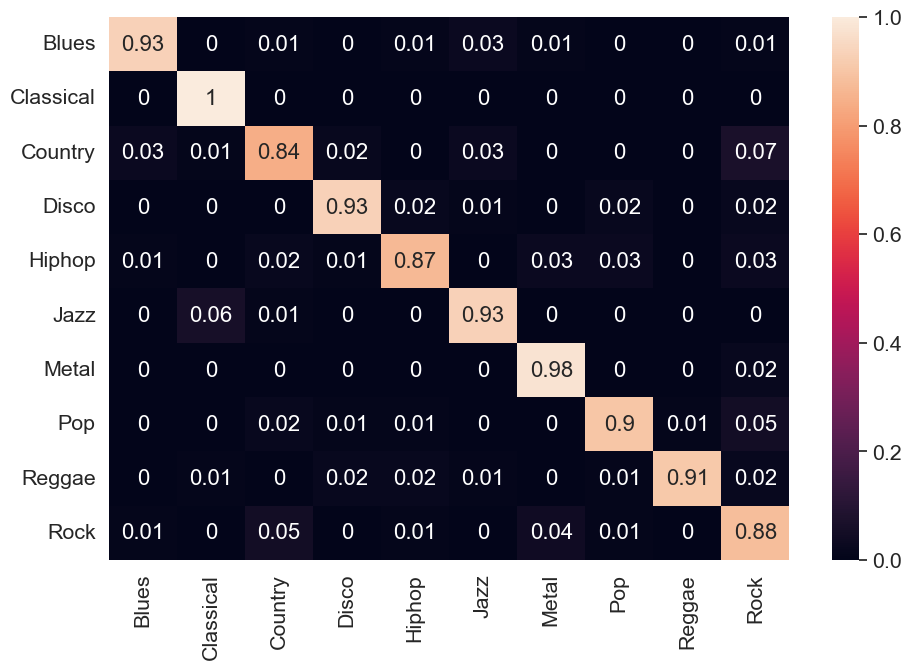

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8987, 128, 130, 1) (8987,) Test:  (999, 128, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

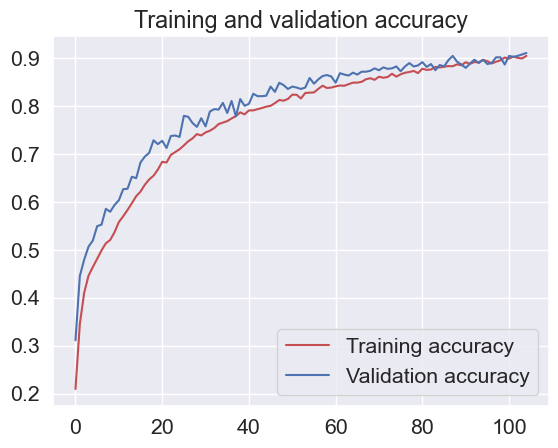

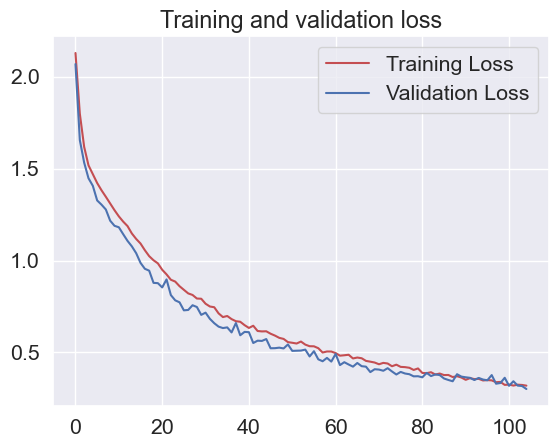

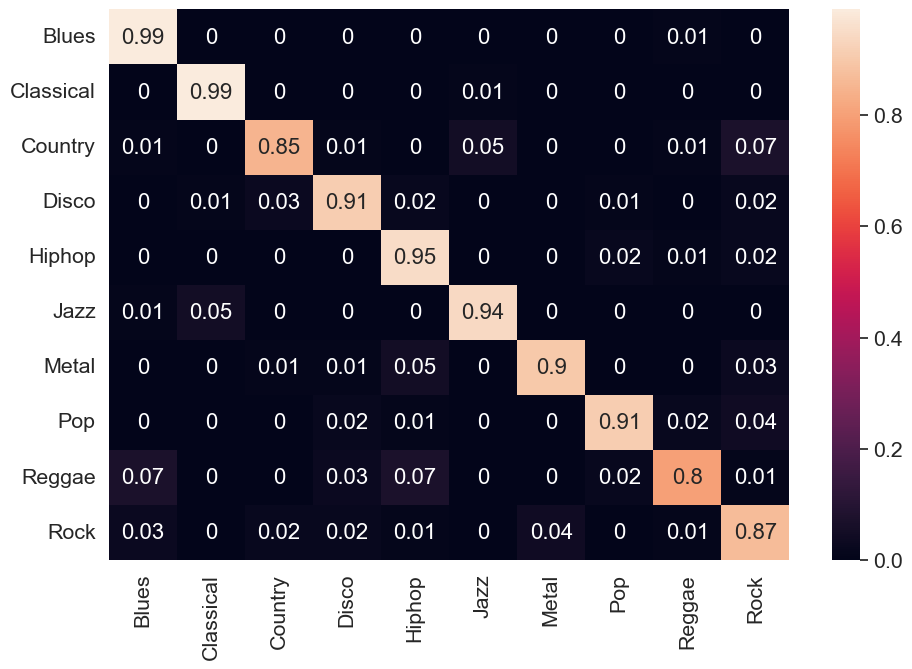

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8987, 128, 130, 1) (8987,) Test:  (999, 128, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

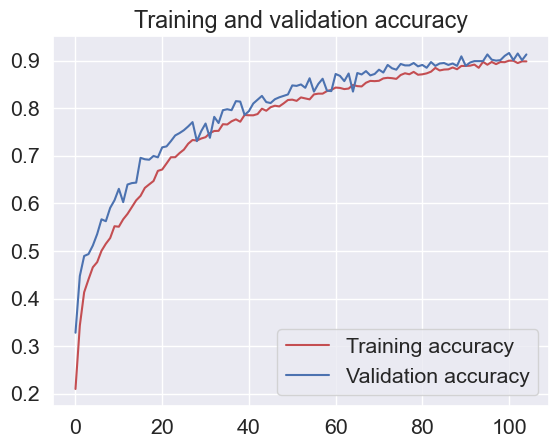

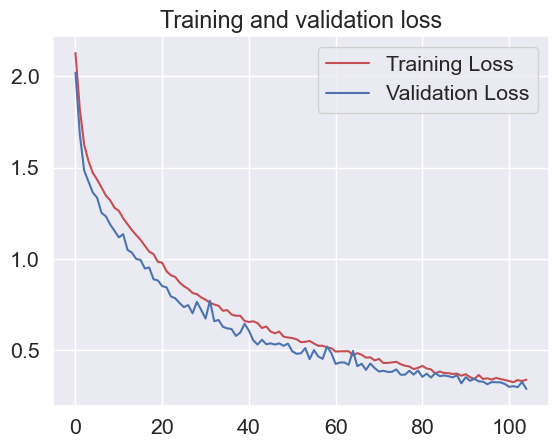

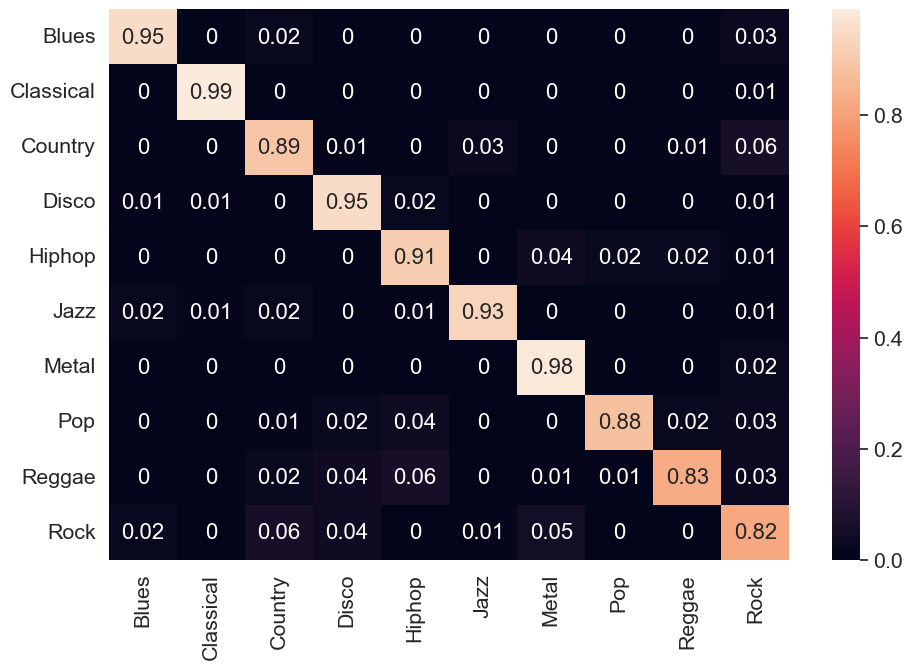

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8987, 128, 130, 1) (8987,) Test:  (999, 128, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

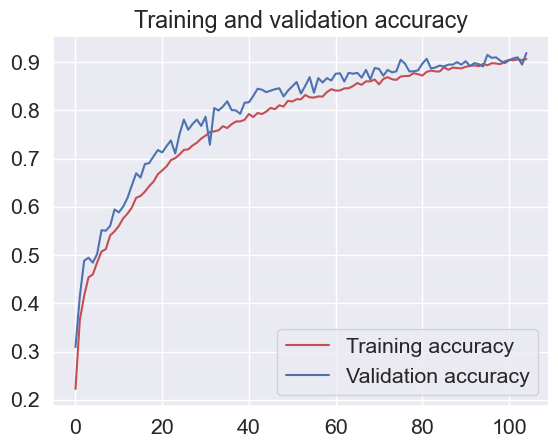

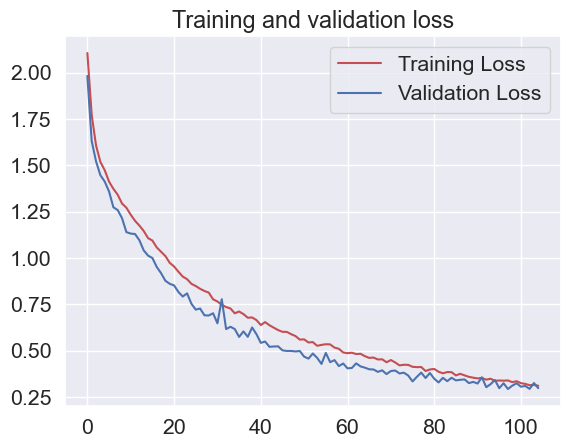

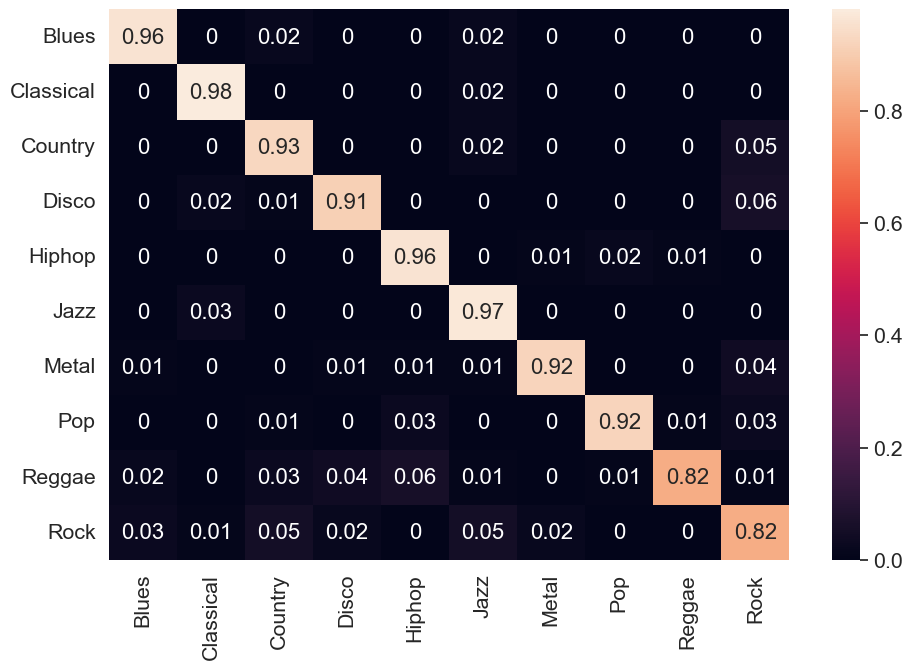

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 899]
 [  4 900]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4  99]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8988, 128, 130, 1) (8988,) Test:  (998, 128, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

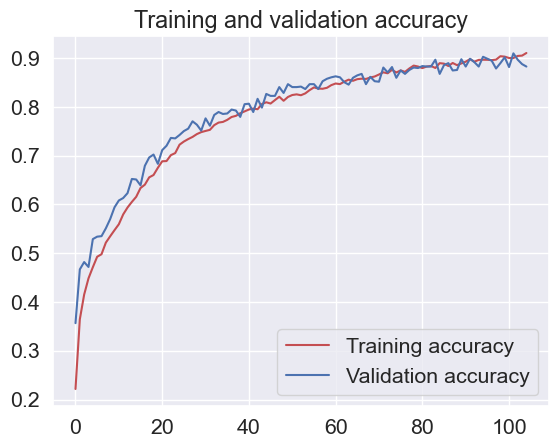

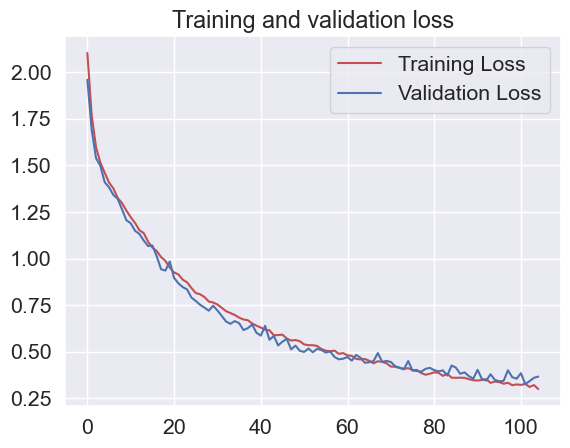

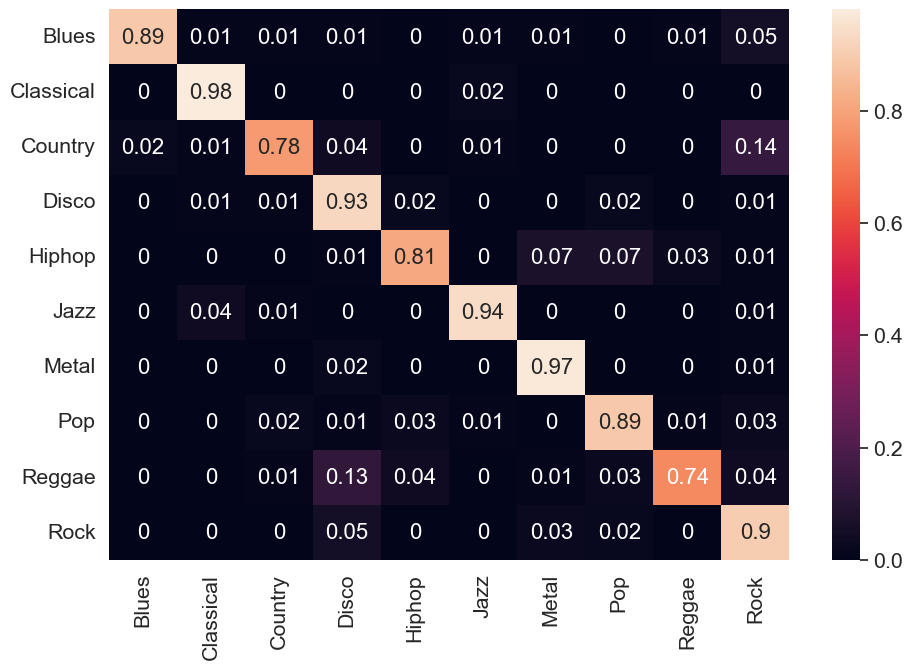

[[  0 900]
 [  1 899]
 [  2 900]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2  99]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8988, 128, 130, 1) (8988,) Test:  (998, 128, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

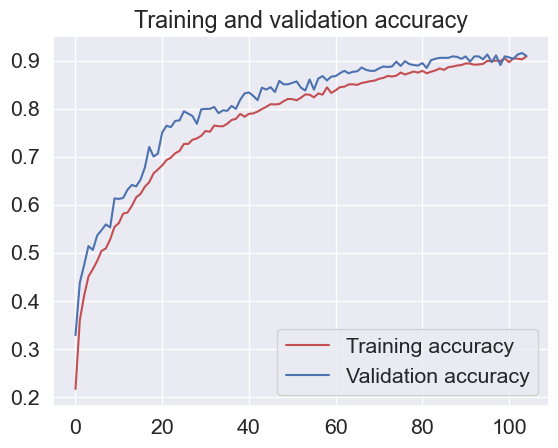

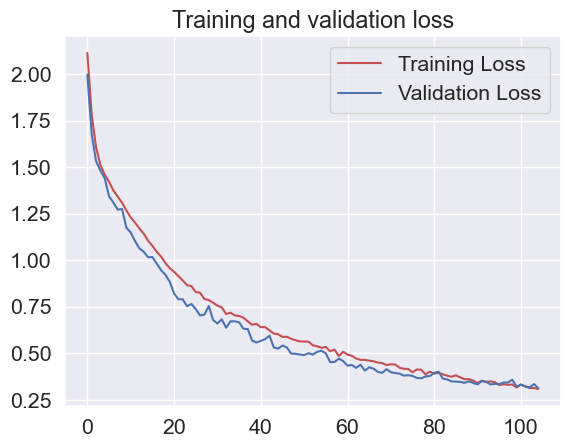

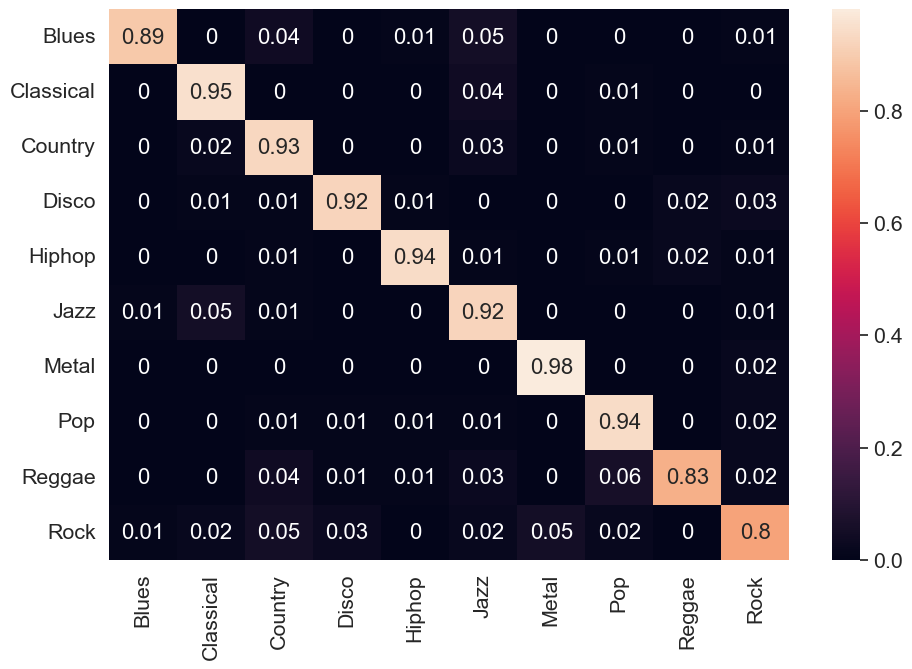

[[  0 900]
 [  1 900]
 [  2 899]
 [  3 899]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1  99]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8988, 128, 130, 1) (8988,) Test:  (998, 128, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

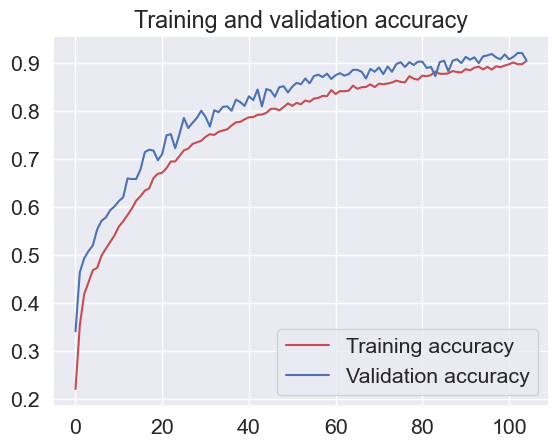

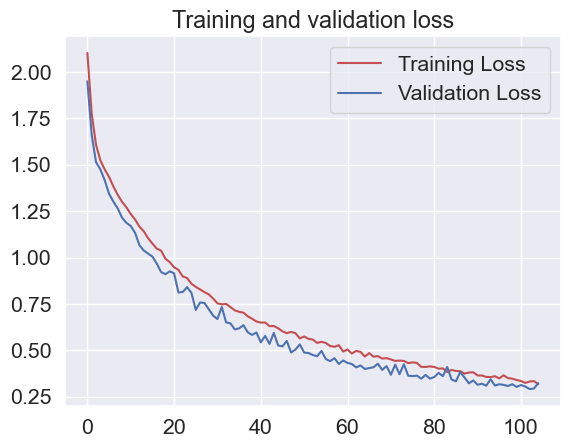

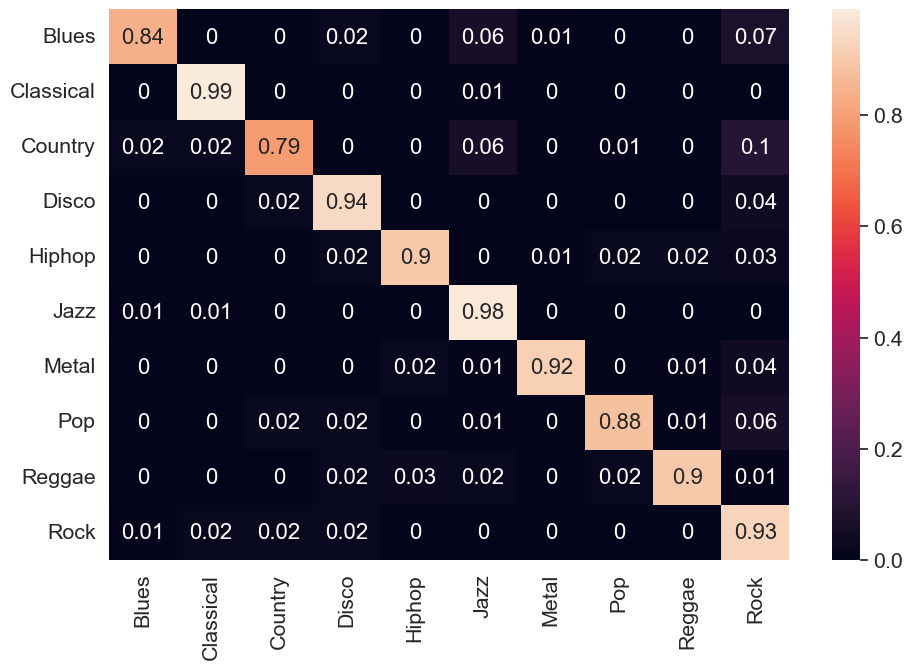

[[  0 900]
 [  1 899]
 [  2 899]
 [  3 900]
 [  4 899]
 [  5 891]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]
[[  0 100]
 [  1 100]
 [  2 100]
 [  3  99]
 [  4 100]
 [  5  99]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]]
Train:  (8988, 128, 130, 1) (8988,) Test:  (998, 128, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                             

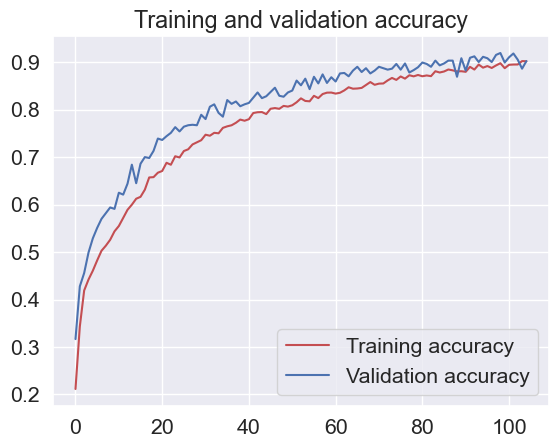

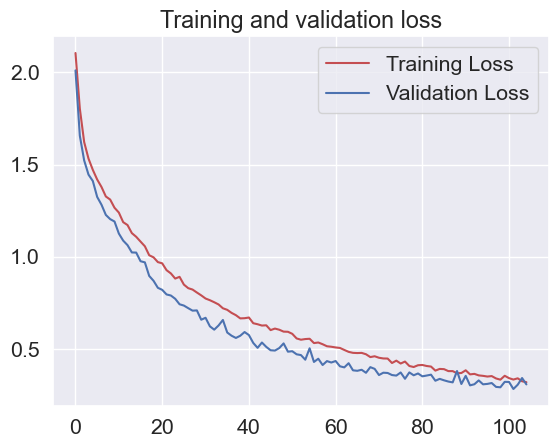

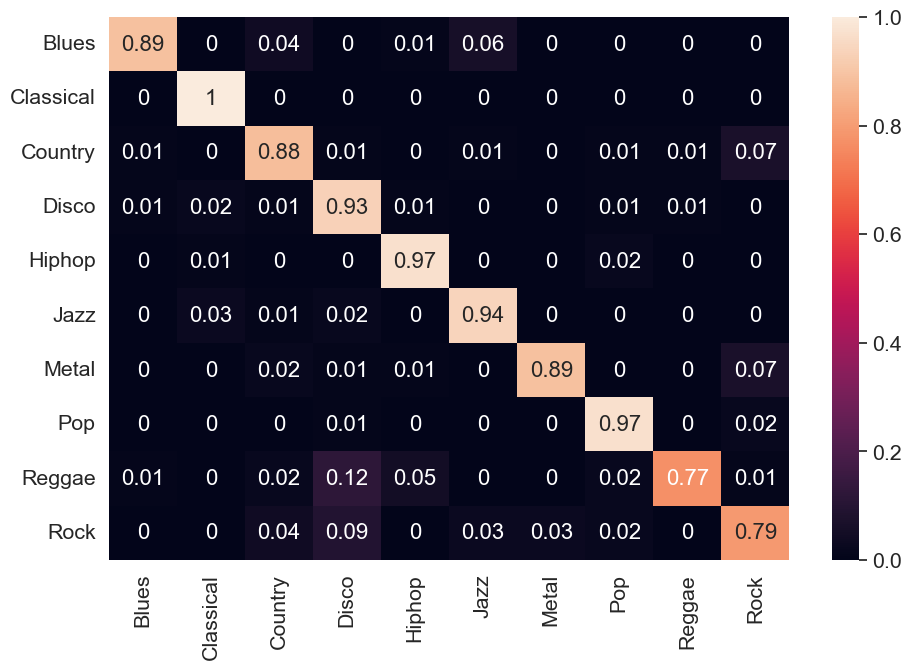

In [13]:
x, y = shuffle(x, y)
skf = StratifiedKFold(n_splits=10)
# kf = KFold(n_splits=10, shuffle=True)
test_accuracies = []
for fold, (train_index, test_index) in enumerate(skf.split(x, y)):
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]

    unique, counts = np.unique(y_train, return_counts=True)
    print(np.asarray((unique, counts)).T)
    unique, counts = np.unique(y_test, return_counts=True)
    print(np.asarray((unique, counts)).T)

    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    print('Train: ', x_train.shape, y_train.shape, 'Test: ', x_test.shape, y_test.shape)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std


    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    model = build_model(input_shape)
    optimizer = keras.optimizers.Adam(learning_rate=0.0002) #0.0002
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.summary()

    # checkpoint_filepath = 'CNN-KFoldCV_Checkpoint/' + str(fold)
    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, initial_value_threshold=0.8, verbose=1)

    history = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              epochs=105, # 90
              batch_size=32 #, callbacks=[model_checkpoint_callback]
              )

    # model.load_weights(checkpoint_filepath)

    test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    test_accuracies.append(test_accuracy)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy' + str())
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()



    print("Accuracy on test set is:{}".format(test_accuracy))

    predictions = model.predict(x_test, batch_size=32, verbose=1)
    predicted_indexes = []
    for prediction in predictions:
        predicted_indexes.append(np.argmax(prediction))
    predicted_indexes
    conf_mat = confusion_matrix(y_test, predicted_indexes, normalize= 'true')
    conf_mat = np.round(conf_mat, 2)
    conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)
    plt.figure(figsize = (10,7), dpi = 100)
    sn.set(font_scale=1.4)
    sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
    plt.tight_layout()

    plt.show()

    del model
    keras.backend.clear_session()
    gc.collect()

In [12]:
del model
keras.backend.clear_session()
gc.collect()

NameError: name 'model' is not defined

In [14]:
test_accuracies = np.array(test_accuracies)
print(test_accuracies, test_accuracies.dtype)
print('Mean = ', np.mean(test_accuracies))
print('Standard deviation = ', np.std(test_accuracies))

[0.92792791 0.91991991 0.91691691 0.9109109  0.91291291 0.91891891
 0.88276553 0.90981966 0.90681362 0.90280563] float64
Mean =  0.9109711885452271
Standard deviation =  0.011622171042012673


In [13]:
x, y = shuffle(x, y)
x = x[..., np.newaxis]

print('Shape: ', x.shape, y.shape)

mean = np.mean(x)
std = np.std(x)
x = (x - mean) / std

Shape:  (9986, 128, 130, 1) (9986,)


In [14]:
input_shape = (x.shape[1], x.shape[2], x.shape[3])
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 43, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 42, 43, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 41, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                    

Epoch 1/90
313/313 [==============================] - 11s 31ms/step - loss: 2.0984 - accuracy: 0.2168
Epoch 2/90
313/313 [==============================] - 10s 31ms/step - loss: 1.7508 - accuracy: 0.3668
Epoch 3/90
313/313 [==============================] - 10s 30ms/step - loss: 1.5974 - accuracy: 0.4155
Epoch 4/90
313/313 [==============================] - 10s 30ms/step - loss: 1.4950 - accuracy: 0.4547
Epoch 5/90
313/313 [==============================] - 10s 30ms/step - loss: 1.4530 - accuracy: 0.4749
Epoch 6/90
313/313 [==============================] - 10s 31ms/step - loss: 1.3937 - accuracy: 0.5033
Epoch 7/90
313/313 [==============================] - 10s 30ms/step - loss: 1.3597 - accuracy: 0.5120
Epoch 8/90
313/313 [==============================] - 10s 30ms/step - loss: 1.3143 - accuracy: 0.5266
Epoch 9/90
313/313 [==============================] - 10s 31ms/step - loss: 1.2909 - accuracy: 0.5359
Epoch 10/90
313/313 [==============================] - 10s 31ms/step - loss: 1.244

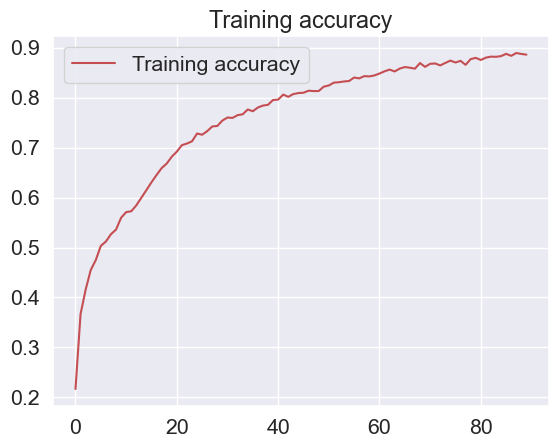

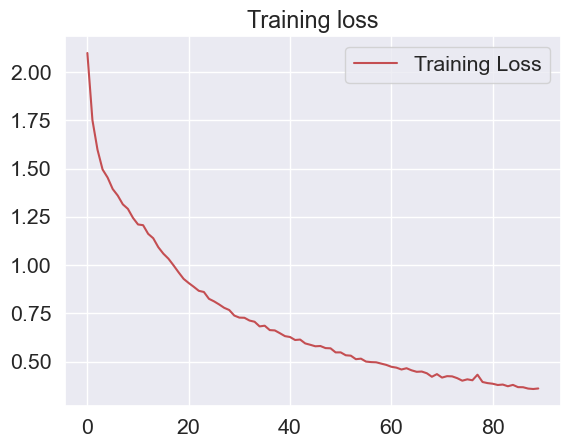

In [15]:
history = model.fit(x, y,
          epochs=90,
          batch_size=32
          )

# test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [16]:
model.save('saved_models/CNN-MEL-Kfold')
mean_std = np.array([mean, std], dtype=np.float32)


INFO:tensorflow:Assets written to: saved_models/CNN-MEL-Kfold\assets


INFO:tensorflow:Assets written to: saved_models/CNN-MEL-Kfold\assets


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/CNN-MEL-Kfold-mean_std/mean_std.npy'

In [17]:
np.save('saved_models/CNN-MEL-Kfold-mean_std/mean_std.npy', mean_std)